In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM
from datasets import load_dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix, binary_f1_score
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd
from huggingface_hub import notebook_login
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict, deque
from sklearn.model_selection import train_test_split
import random
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")

import re
from typing import List, Dict
    
from src.preprocessing.sequence_classification.dataset import get_n_shots_per_class
from src.model.mlm.pet_for_text_classification import train 
import warnings
warnings.filterwarnings("ignore")

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
!mkdir logs
model_name = "PET"
dataset_name = "RAFT-Ade-corpus"
logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)
device = "cuda" if torch.cuda.is_available() else "cpu"

mkdir: cannot create directory ‘logs’: File exists


## Loading dataset

In [4]:
ade_corpus_dataset = load_dataset(
    "ade_corpus_v2", 
    name= "Ade_corpus_v2_classification",
    cache_dir= "/Data/pedro.silva"
)

In [5]:
classes = np.unique(ade_corpus_dataset['train']['label'], return_counts=True)
classes

(array([0, 1]), array([16695,  6821]))

In [6]:
train_size = 0.7
def stratified_train_test_split(
    dataset : Dataset,
    classes : np.ndarray,
    train_size : float
):
    """Performs train test split keeping class distributions

    Args:
        dataset (Dataset): _description_
        classes (np.ndarray): _description_
        train_size (float): _description_

    Returns:
        _type_: _description_
    """    

    if isinstance(dataset, pd.DataFrame):
        df = dataset

    else:
        df = dataset.to_pandas()
        
    indexes_dict = {}
    for label in classes[0]:
        indexes_dict[label] = df.query(f"label == {label}")


    
    train_data = {
        'label': [],
        'text': []
    }

    validation_data = {
        "label" : [],
        "text": []
    }

    class_proportion = df['label'].value_counts()/len(df)

    # generating train data
    for label in classes[0]:
        n = len(indexes_dict[label])

        if isinstance(train_size, int):
            size = round(class_proportion[label] * train_size)
            
        else:
            size = int(train_size * n)

        train_data['text'] += df.query(f"label == {label}")\
            [0:size]\
            ['text']\
            .to_list()
        
        train_data['label'] += [label]*size
        
        validation_data['text'] +=df.query(f"label == {label}")\
            [size:]\
            ['text']\
            .to_list()
        
        validation_data['label'] += [label]* (n-size)

    return train_data, validation_data

## Few shot learning study - 50 shots

In [7]:
classes = np.unique(ade_corpus_dataset['train']['label'], return_counts=True)
train_validation, test_df = stratified_train_test_split(
    ade_corpus_dataset['train'],
    classes,
    train_size = 50
)

In [8]:
train_df, val_df  = stratified_train_test_split(
    pd.DataFrame(train_validation),
    classes,
    30
)

In [9]:
val_df = pd.DataFrame(val_df).to_dict('list')
test_df = pd.DataFrame(test_df).sample(n = 1000).to_dict('list')

In [10]:
def pattern1(text: str, tokenizer : AutoTokenizer):
    return f"{text} Are any there adverse drug effects ? {tokenizer.mask_token}"

In [11]:

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased",
                                          cache_dir = "/Data/pedro.silva")
idx2class = {
    0: "no",
    1: "yes"
}

class2idx = {
    "no": 0,
    "yes": 1
}

class_names = ['no', 'yes']

verbalizer = {idx : tokenizer.vocab[x.lower()] for idx, x in enumerate(class_names)}
inverse_verbalizer = {tokenizer.vocab[x.lower()] : idx for idx, x in enumerate(class_names)}

In [12]:
verbalizer

{0: 2053, 1: 2748}

In [13]:

def preprocess(text : List[str], labels : List[int]):

    processed_text = []
    processed_labels = []
    for idx in range(len(text)):
        label = idx2class[labels[idx]]
        text_ = text[idx]

        processed_text.append(pattern1(text_, tokenizer))
        processed_labels.append(label)

    return processed_text, processed_labels

In [14]:
train_text, train_labels = preprocess(train_df['text'], train_df['label'])
val_text, val_labels = preprocess(val_df['text'], val_df['label'])
test_text, test_labels = preprocess(test_df['text'], test_df['label'])

In [15]:
class PETDatasetForClassification(Dataset):
    def __init__(
        self, 
        processed_text : List[str], 
        labels : List[int],
        tokenizer : AutoTokenizer,
        device : str = "cuda"
    ) -> None:
        super().__init__()

        self.tokens = tokenizer(
            processed_text,
            return_tensors="pt",
            padding="max_length",
            truncation=True
        )
        self.encoded_labels = deepcopy(self.tokens['input_ids'])
        
        self.encoded_labels[self.encoded_labels != tokenizer.mask_token_id] = -100

        for idx, sentence in tqdm(enumerate(self.encoded_labels)):
            sentence[sentence == tokenizer.mask_token_id] = tokenizer.vocab[labels[idx].lower()]

        self.inputs : Dict[str, torch.Tensor] = self.tokens
        self.inputs['labels'] = self.encoded_labels

        for k,v in self.inputs.items():
            self.inputs[k] = v.to(device)

    def __getitem__(self, index):
        d : Dict = dict()
        for key in self.inputs.keys():
            d[key] = self.inputs[key][index]

        return d
    
    def __len__(self):
        return self.tokens['input_ids'].shape[0]

In [16]:
train_dataset = PETDatasetForClassification(
    train_text,
    train_labels,
    tokenizer
)

val_dataset = PETDatasetForClassification(
    val_text,
    val_labels,
    tokenizer
)

test_dataset = PETDatasetForClassification(
    test_text,
    test_labels,
    tokenizer
)

0it [00:00, ?it/s]

30it [00:00, 65.05it/s]
20it [00:00, 67.19it/s]
1000it [00:09, 102.73it/s]


In [17]:
train_dataloader = DataLoader(train_dataset, shuffle= True)
val_dataloader =DataLoader(val_dataset)
test_dataloader = DataLoader(test_dataset)

In [18]:
_, class_counts = np.unique(
    train_df['label'],
    return_counts=True,
)

alpha = len(train_df['label'])/class_counts

# ------------ val -----------------------------------

_, class_counts_val = np.unique(
    val_df['label'],
    return_counts=True,
)
alpha_val = len(val_df['label'])/class_counts_val

# ----------- test ------------------------------------

_, class_counts_test = np.unique(
    test_df['label'],
    return_counts=True,
)
alpha_test = len(test_df['label'])/class_counts_test
alpha, alpha_val, alpha_test

(array([1.42857143, 3.33333333]),
 array([1.42857143, 3.33333333]),
 array([1.38121547, 3.62318841]))

In [19]:
from src.utils import FocalLoss

In [20]:
classes

(array([0, 1]), array([16695,  6821]))

In [35]:
model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased",
                                             cache_dir = "/Data/pedro.silva").to(device)
history, confusion_matrix, best_model = train(
    train_dataloader,
    val_dataloader,
    num_classes = 2,
    model = model,
    verbalizer = verbalizer,
    tokenizer=tokenizer,
    alpha = 1e-6,
    lr=1e-3,
    evaluation_fn= binary_f1_score,
    loss_fn=FocalLoss(alpha, gamma=1),
    n_epochs=10
)

Epoch 9
f1-score : 0.5
tensor([[14,  0],
        [ 4,  2]], device='cuda:0')


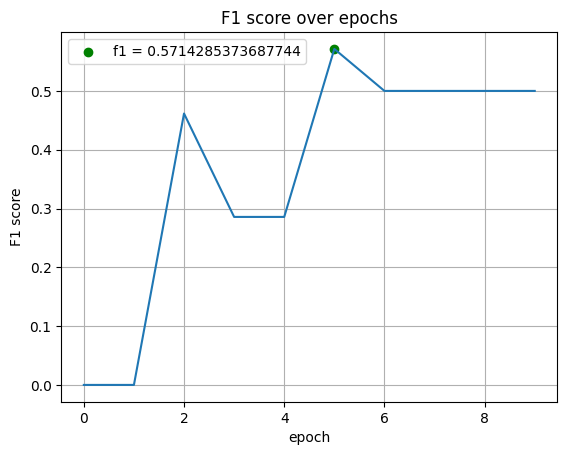

In [36]:
plt.plot(history)
plt.scatter(
    np.argmax(history),
    np.max(history),
    label = f"f1 = {np.max(history)}",
    c = "green"
)

plt.grid()
plt.title("F1 score over epochs")
plt.xlabel("epoch")
plt.ylabel("F1 score")
plt.legend()

Text(0.5, 1.0, 'Confusion Matrix RAFT-Ade-corpus - PET')

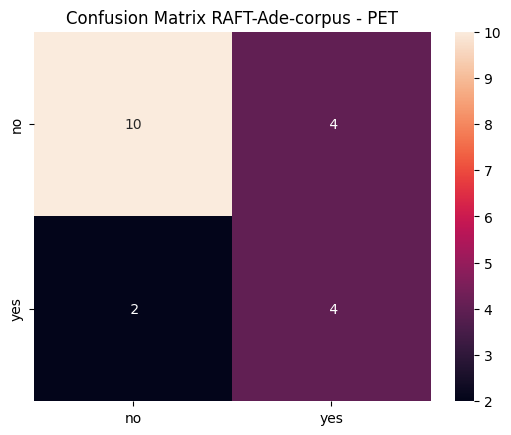

In [37]:
df = pd.DataFrame(
    confusion_matrix.to("cpu").numpy(),
    index = class_names,
    columns=class_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - PET")

## Test results

In [38]:
from src.model.mlm.pet_for_text_classification import get_y_true

In [39]:
with torch.no_grad():
    y_true_test = torch.tensor([],device=device)
    y_pred_test = torch.tensor([],device=device)

    for input in tqdm(test_dataloader):
        out = best_model(**input)

        y_true = get_y_true(
            input,
            inverse_verbalizer
        )

        try:
            mask_token_index = torch.where(input["input_ids"] == tokenizer.mask_token_id)[1]

        except:
            mask_token_index = torch.where(input["input_ids"] == tokenizer.mask_token_id)[0]
        mask_token_logits = out.logits[0, mask_token_index, :]
        
        predictions = torch.Tensor(
            [mask_token_logits[0,x] for x in verbalizer.values()]
        )

        y_pred = predictions.argmax().to(device)

        y_pred_test = torch.cat([
            y_pred_test, 
            torch.tensor([y_pred]).to(device)
        ])

        y_true_test = torch.cat([
            y_true_test,
            torch.tensor([y_true]).to(device)
        ])
    
    f1 = binary_f1_score(
        y_pred_test,
        y_true_test,
        # num_classes= len(classes[0])
    )

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:09<00:00, 109.05it/s]


In [40]:
f1

tensor(0.4746, device='cuda:0')

Text(0.5, 1.0, 'Confusion Matrix RAFT-Ade-corpus - PET')

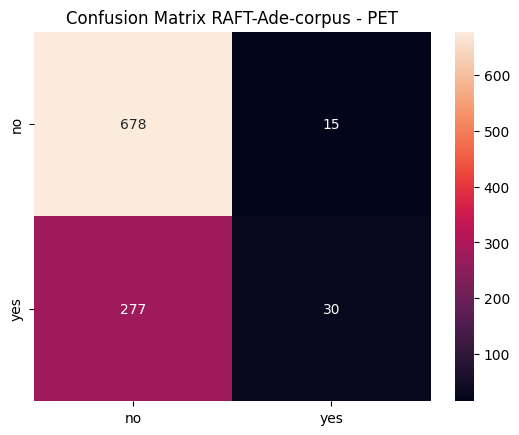

In [32]:
conf_matrix = multiclass_confusion_matrix(
    y_pred_test.to(torch.int64),
    y_true_test.to(torch.int64),
    num_classes= len(classes[0])
)

df = pd.DataFrame(
    conf_matrix.to("cpu").numpy(),
    index = class_names,
    columns=class_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - PET")

## General approach - 500 shots

In [7]:
classes = np.unique(ade_corpus_dataset['train']['label'], return_counts=True)
n_shots = 500
train_validation, test_df = stratified_train_test_split(
    ade_corpus_dataset['train'],
    classes,
    train_size = n_shots
)

In [8]:
train_df, val_df = stratified_train_test_split(
    pd.DataFrame(train_validation),
    classes,
    300
)

In [9]:
val_df = pd.DataFrame(val_df).to_dict('list')
test_df = pd.DataFrame(test_df).sample(n = 1000).to_dict('list')

In [10]:
def pattern1(text: str, tokenizer : AutoTokenizer):
    return f"{text} Are any there adverse drug effects ? {tokenizer.mask_token}"

In [11]:

tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-large",
                                          cache_dir = "/Data/pedro.silva")
idx2class = {
    0: "no",
    1: "yes"
}

class2idx = {
    "no": 0,
    "yes": 1
}

class_names = ['no', 'yes']

verbalizer = {idx : tokenizer.vocab[x.lower()] for idx, x in enumerate(class_names)}
inverse_verbalizer = {tokenizer.vocab[x.lower()] : idx for idx, x in enumerate(class_names)}

In [12]:
verbalizer

{0: 2362, 1: 10932}

In [13]:

def preprocess(text : List[str], labels : List[int]):

    processed_text = []
    processed_labels = []
    for idx in range(len(text)):
        label = idx2class[labels[idx]]
        text_ = text[idx]

        processed_text.append(pattern1(text_, tokenizer))
        processed_labels.append(label)

    return processed_text, processed_labels

In [14]:
train_text, train_labels = preprocess(train_df['text'], train_df['label'])
val_text, val_labels = preprocess(val_df['text'], val_df['label'])
test_text, test_labels = preprocess(test_df['text'], test_df['label'])

In [15]:
class PETDatasetForClassification(Dataset):
    def __init__(
        self, 
        processed_text : List[str], 
        labels : List[int],
        tokenizer : AutoTokenizer,
        device : str = "cuda"
    ) -> None:
        super().__init__()

        self.tokens = tokenizer(
            processed_text,
            return_tensors="pt",
            padding="max_length",
            truncation=True
        )
        self.encoded_labels = deepcopy(self.tokens['input_ids'])
        
        self.encoded_labels[self.encoded_labels != tokenizer.mask_token_id] = -100

        for idx, sentence in tqdm(enumerate(self.encoded_labels)):
            sentence[sentence == tokenizer.mask_token_id] = tokenizer.vocab[labels[idx].lower()]

        self.inputs : Dict[str, torch.Tensor] = self.tokens
        self.inputs['labels'] = self.encoded_labels

        for k,v in self.inputs.items():
            self.inputs[k] = v.to(device)

    def __getitem__(self, index):
        d : Dict = dict()
        for key in self.inputs.keys():
            d[key] = self.inputs[key][index]

        return d
    
    def __len__(self):
        return self.tokens['input_ids'].shape[0]

In [16]:
train_dataset = PETDatasetForClassification(
    train_text,
    train_labels,
    tokenizer
)

val_dataset = PETDatasetForClassification(
    val_text,
    val_labels,
    tokenizer
)

test_dataset = PETDatasetForClassification(
    test_text,
    test_labels,
    tokenizer
)

6it [00:00, 56.88it/s]

300it [00:04, 74.19it/s]
200it [00:02, 76.84it/s]
1000it [00:13, 75.92it/s]


In [17]:
train_dataloader = DataLoader(train_dataset, shuffle= True)
val_dataloader =DataLoader(val_dataset)
test_dataloader = DataLoader(test_dataset)

In [18]:
_, class_counts = np.unique(
    train_df['label'],
    return_counts=True,
)

alpha = len(train_df['label'])/class_counts

# ------------ val -----------------------------------

_, class_counts_val = np.unique(
    val_df['label'],
    return_counts=True,
)
alpha_val = len(val_df['label'])/class_counts_val

# ----------- test ------------------------------------

_, class_counts_test = np.unique(
    test_df['label'],
    return_counts=True,
)
alpha_test = len(test_df['label'])/class_counts_test
alpha, alpha_val, alpha_test

(array([1.4084507 , 3.44827586]),
 array([1.4084507 , 3.44827586]),
 array([1.37551582, 3.66300366]))

In [19]:
from src.utils import FocalLoss

In [20]:
classes

(array([0, 1]), array([16695,  6821]))

In [21]:
model = AutoModelForMaskedLM.from_pretrained("FacebookAI/roberta-large",
                                             cache_dir = "/Data/pedro.silva").to(device)
history, confusion_matrix, best_model = train(
    train_dataloader,
    val_dataloader,
    num_classes = 2,
    model = model,
    verbalizer = verbalizer,
    tokenizer=tokenizer,
    alpha = 1e-5,
    evaluation_fn= binary_f1_score,
    loss_fn=FocalLoss(alpha, gamma=1),
    n_epochs=5
)

Epoch 4
f1-score : 0.695652186870575
tensor([[110,  32],
        [ 10,  48]], device='cuda:0')


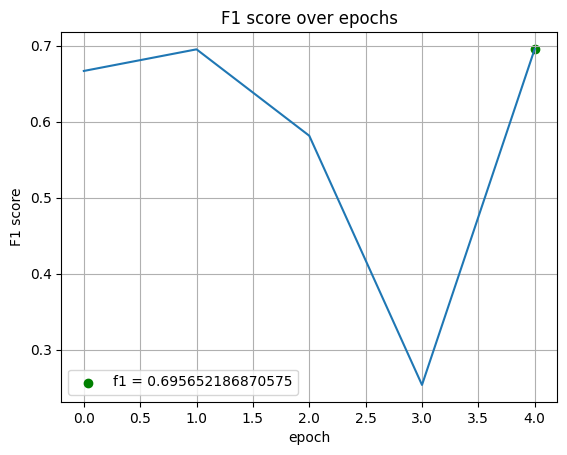

In [22]:
plt.plot(history)
plt.scatter(
    np.argmax(history),
    np.max(history),
    label = f"f1 = {np.max(history)}",
    c = "green"
)

plt.grid()
plt.title("F1 score over epochs")
plt.xlabel("epoch")
plt.ylabel("F1 score")
plt.legend()

Text(0.5, 1.0, 'Confusion Matrix RAFT-Ade-corpus - PET')

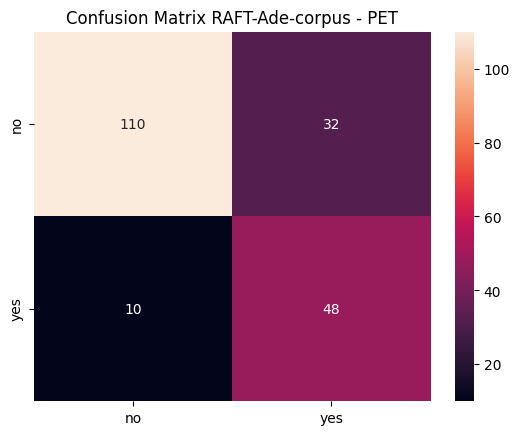

In [23]:
df = pd.DataFrame(
    confusion_matrix.to("cpu").numpy(),
    index = class_names,
    columns=class_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - PET")

## Test results

In [24]:
from src.model.mlm.pet_for_text_classification import get_y_true

In [27]:
with torch.no_grad():
    y_true_test = torch.tensor([],device=device)
    y_pred_test = torch.tensor([],device=device)

    for input in tqdm(test_dataloader):
        out = model(**input)

        y_true = get_y_true(
            input,
            inverse_verbalizer
        )

        try:
            mask_token_index = torch.where(input["input_ids"] == tokenizer.mask_token_id)[1]

        except:
            mask_token_index = torch.where(input["input_ids"] == tokenizer.mask_token_id)[0]
        mask_token_logits = out.logits[0, mask_token_index, :]
        
        predictions = torch.Tensor(
            [mask_token_logits[0,x] for x in verbalizer.values()]
        )

        y_pred = predictions.argmax().to(device)

        y_pred_test = torch.cat([
            y_pred_test, 
            torch.tensor([y_pred]).to(device)
        ])

        y_true_test = torch.cat([
            y_true_test,
            torch.tensor([y_true]).to(device)
        ])
    
    f1 = binary_f1_score(
        y_pred_test,
        y_true_test,
        # num_classes= len(classes[0])
    )

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:39<00:00, 25.61it/s]


In [28]:
f1

tensor(0.7593, device='cuda:0')